In [1]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from torchvision import datasets

# Set debug flag to run on CPU for detailed error messages
debug = True

# Set CUDA_LAUNCH_BLOCKING=1 for detailed stack trace
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

class FlatDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

def create_data_loaders(train_dir, test_dir, batch_size=32):
    train_dataset = datasets.ImageFolder(root=os.path.join(train_dir, 'Labeled'), transform=data_transforms['train'])
    print("Unique labels in the training dataset:", set(train_dataset.targets))
    test_dataset = FlatDataset(image_dir=os.path.join(test_dir, 'image'), transform=data_transforms['test'])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, test_loader, train_dataset.class_to_idx

def initialize_model(num_classes):
    model = models.resnet50(weights='DEFAULT')
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def train_model(model, train_loader, criterion, optimizer, num_epochs=6):
    device = torch.device('cuda' if torch.cuda.is_available() and not debug else 'cpu')
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            if not torch.all((labels >= 0) & (labels < model.fc.out_features)):
                raise ValueError(f"Invalid label found: {labels}")

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct / total
        print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Accuracy: {epoch_accuracy:.4f}')

    return model

def pseudo_labeling(model, unlabeled_loader):
    device = torch.device('cuda' if torch.cuda.is_available() and not debug else 'cpu')
    model.eval()
    pseudo_labels = []

    with torch.no_grad():
        for inputs in unlabeled_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            pseudo_labels.extend(preds.cpu().numpy())

    return pseudo_labels

def combine_datasets(labeled_dataset, pseudo_labels, unlabeled_dir):
    pseudo_dataset = FlatDataset(image_dir=unlabeled_dir, transform=data_transforms['test'])
    pseudo_dataset.pseudo_labels = pseudo_labels
    combined_dataset = torch.utils.data.ConcatDataset([labeled_dataset, pseudo_dataset])
    return combined_dataset

def make_predictions(model, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() and not debug else 'cpu')
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())

    return predictions


In [2]:
train_loader, test_loader, class_to_idx = create_data_loaders(
    '/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train',
    '/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Test'
)

num_classes = len(class_to_idx)
print(f"Number of classes: {num_classes}, Class to index mapping: {class_to_idx}")
model = initialize_model(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

model = train_model(model, train_loader, criterion, optimizer)

Unique labels in the training dataset: {0, 1}
Number of classes: 2, Class to index mapping: {'Flooded': 0, 'Non-Flooded': 1}


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


Epoch 0/5 Loss: 0.4697 Accuracy: 0.8480
Epoch 1/5 Loss: 0.3366 Accuracy: 0.8769
Epoch 2/5 Loss: 0.2842 Accuracy: 0.9083
Epoch 3/5 Loss: 0.2662 Accuracy: 0.9108
Epoch 4/5 Loss: 0.2517 Accuracy: 0.9221
Epoch 5/5 Loss: 0.2508 Accuracy: 0.9246


In [3]:
class FlatDataset(Dataset):
    def __init__(self, image_dir, transform=None, pseudo_labels=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.pseudo_labels = pseudo_labels

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Return pseudo labels if available
        if self.pseudo_labels is not None:
            return image, self.pseudo_labels[idx]
        else:
            return image

def combine_datasets(labeled_dataset, pseudo_labels, unlabeled_dir):
    pseudo_dataset = FlatDataset(image_dir=unlabeled_dir, transform=data_transforms['test'], pseudo_labels=pseudo_labels)
    combined_dataset = torch.utils.data.ConcatDataset([labeled_dataset, pseudo_dataset])
    return combined_dataset

def custom_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, 0)
    labels = torch.tensor(labels)
    return images, labels

unlabeled_dataset = FlatDataset('/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Unlabeled/image', transform=data_transforms['test'])
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=False, num_workers=4)

pseudo_labels = pseudo_labeling(model, unlabeled_loader)

In [4]:
combined_dataset = combine_datasets(train_loader.dataset, pseudo_labels, '/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Unlabeled/image')
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)

In [5]:
model = train_model(model, combined_loader, criterion, optimizer)

Epoch 0/5 Loss: 0.1546 Accuracy: 0.9544
Epoch 1/5 Loss: 0.1369 Accuracy: 0.9626
Epoch 2/5 Loss: 0.1326 Accuracy: 0.9604
Epoch 3/5 Loss: 0.1270 Accuracy: 0.9620
Epoch 4/5 Loss: 0.1236 Accuracy: 0.9604
Epoch 5/5 Loss: 0.1184 Accuracy: 0.9658


ValueError: num must be an integer with 1 <= num <= 16, not 17

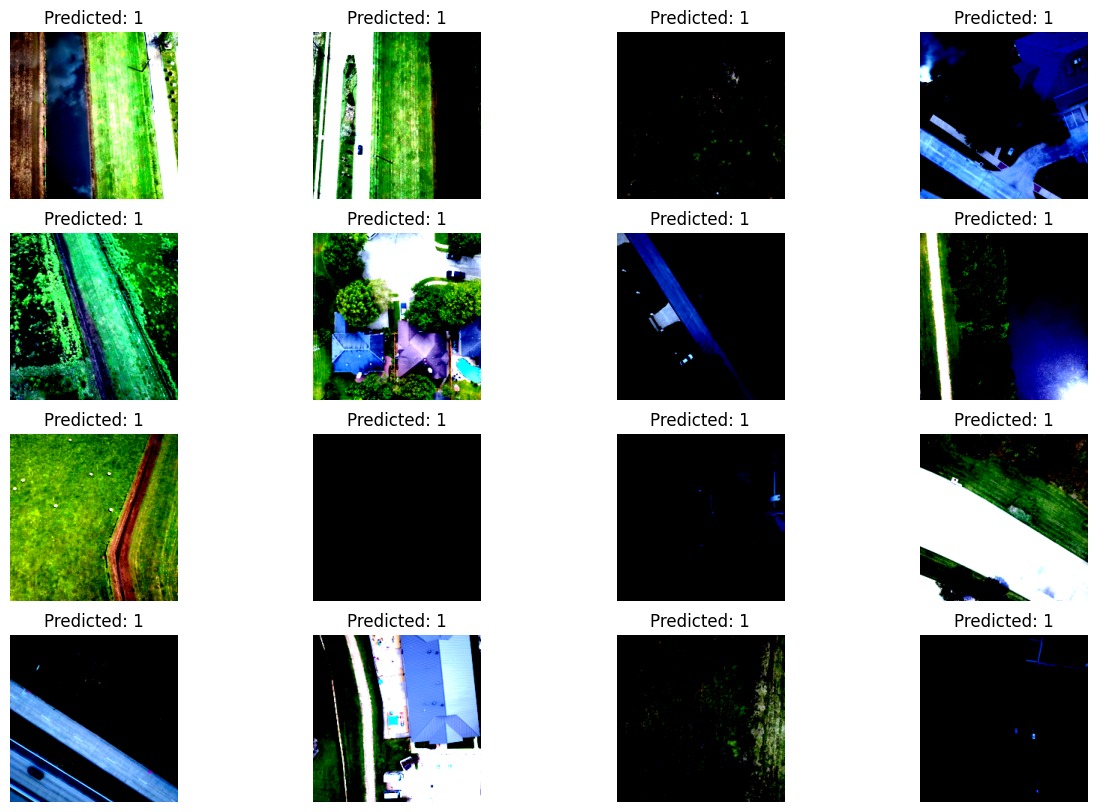

In [6]:
import matplotlib.pyplot as plt


test_dataset = FlatDataset(image_dir=os.path.join('/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Test', 'image'), transform=data_transforms['test'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

def plot_predictions(test_loader, predictions):
    images = next(iter(test_loader))

    images = images.numpy().transpose((0, 2, 3, 1)) 

    plt.figure(figsize=(15, 10))
    
    for idx in range(len(images)):  
        plt.subplot(4, 4, idx + 1)
        plt.imshow(images[idx])
        plt.title(f'Predicted: {predictions[idx]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

test_predictions = make_predictions(model, test_loader)
plot_predictions(test_loader, test_predictions)

In [ ]:
torch.save(model.state_dict(), "floodnet.pth")